# E-commerce Recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Business Understanding

### Project Overview
E-commerce platforms rely on personalized recommendations to improve user experience, increase engagement, and drive sales. Customers interact with products through various events such as **views, clicks, and add-to-cart actions**, but these interactions are often unstructured. The goal of this project is to **build a recommendation system that predicts item properties for "add to cart" events based on prior "view" events** while also detecting abnormal user behavior to enhance recommendation accuracy.

### Business Objectives
1. **Improve Personalization**
   - Predict which product properties influence a user's decision to add an item to the cart.
   - Help businesses tailor their recommendations based on implicit browsing behavior.

2. **Reduce Noise and Improve Efficiency**
   - Identify and remove **abnormal users** who introduce bias and noise into the dataset.
   - Ensure data quality for better recommendation performance.

3. **Enhance Customer Engagement and Sales**
   - Deliver relevant product recommendations, increasing conversion rates.
   - Improve user retention by optimizing the browsing experience.

### Problem Statement
- Customers interact with multiple products before making a purchase decision. However, the properties influencing these decisions (e.g., price, brand, availability) are not explicitly logged.
- **How can we infer product properties that contribute to an "add to cart" decision based on past "view" events?**
- Additionally, **how can we detect and filter out abnormal users who distort recommendation accuracy?**

### Data Understanding
The project relies on three key datasets:

#### 1. `events.csv` (User Interaction Data)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the interaction occurred. |
| `visitorid`  | Unique identifier for each user. |
| `event`      | Type of interaction (e.g., view, add to cart). |
| `itemid`     | Unique identifier for each product. |
| `transactionid` | Identifies transactions (for purchases). |

#### 2. `item_properties.csv` (Product Metadata)
| Column       | Description |
|-------------|------------|
| `timestamp`  | Time when the property was recorded. |
| `itemid`     | Product identifier. |
| `property`   | Feature of the product (e.g., category, availability). |
| `value`      | Corresponding value of the property. |

#### 3. `category_tree.csv` (Product Category Data)
| Column       | Description |
|-------------|------------|
| `categoryid`  | Child category identifier |
| `parentid`     | Parent category identifier. |

### Project Scope
- **Task 1:** Develop an algorithm to predict item properties for "add to cart" events based on "view" events.
- **Task 2:** Detect abnormal users who generate noise and remove them to improve recommendation accuracy.

By addressing these tasks, the project will deliver a robust recommendation system that enhances **e-commerce personalization** and **business intelligence insights** while ensuring **clean and reliable data**. 🚀

### Hypothesis Testing
- **Null Hypothesis(Ho):**
- **Alternate Hypothesis(Ha):**

### Analytical Questions
1. Do the most viewed items also have the highest add-to-cart and transaction counts?
2. Does a visitor number of views for a certain item influences his/decision to add the item to cart?
3. What are the most transacted item?
4. How can we detect and filter out abnormal users who distort recommendation accuracy?
5. What are the most add to cart item?
6. Which particular time of the day has the most transactions?
7. What is the view to "add to cart" conversion rate?



#### Import all necessary libraries

In [2]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Statistical Libraries
from scipy import stats
from scipy.stats import ttest_ind

# Feature Engineering Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Machine Learning Libraries
# from lightgbm import LGBMClassifier

# Metrics Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Utils
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

print("Successfully imported all libraries...")

Successfully imported all libraries...


#### Data Understanding

In [3]:
# Load datasets
events_df = pd.read_csv('/content/drive/MyDrive/data/events.csv')
item_properties1_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part1.1.csv')
item_properties2_df = pd.read_csv('/content/drive/MyDrive/data/item_properties_part2.csv', dtype={"property":"object"})
category_tree_df = pd.read_csv('/content/drive/MyDrive/data/category_tree.csv')



In [4]:
# Load the events_df
events_df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [5]:
# Load the category_tree_df
category_tree_df

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [6]:
# Load the item_properties1_df
item_properties1_df

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [7]:
# Load the item_properties2_df
item_properties2_df

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


#### Concatenate the item properties dataframes

In [8]:
item_properties_df = pd.concat([item_properties1_df,item_properties2_df],ignore_index=True)

# Display the first few rows of the concatenated dataframe
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [9]:
# check the shape of the new items_properties_df
item_properties_df.shape

(20275902, 4)

#### Create New Features from Property column of the item_properties

In [10]:
# initialize the categoryid and available columns
item_properties_df["categoryid"] = np.nan
item_properties_df["available"] = np.nan

# Assign values to the new column based on the 'property' column
item_properties_df.loc[item_properties_df["property"] == "categoryid","categoryid"] = item_properties_df["value"]
item_properties_df.loc[item_properties_df["property"] == "available","available"] = item_properties_df["value"]

In [11]:
# Move all the already existing numerical category ids into categoryid column
item_properties_df.loc[item_properties_df["property"].str.isnumeric(), "categoryid"] = item_properties_df["property"]

In [12]:
# create new column called description column
item_properties_df["description"] = item_properties_df.apply(
    lambda row: row["value"] if row["property"] not in ["categoryid","available"] else np.nan, axis=1 )


In [13]:
# drop unnecessary property and value columns
item_properties_df.drop(["property", "value"], axis=1, inplace=True)

In [14]:
# confirm changes
item_properties_df

,timestamp,itemid,categoryid,available,description
0,1435460400000,460429,1338,NaN,NaN
1,1441508400000,206783,888,NaN,1116713 960601 n277.200
2,1439089200000,395014,400,NaN,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,NaN,n15360.000
4,1431831600000,156781,917,NaN,828513
...,...,...,...,...,...
20275897,1433646000000,236931,929,NaN,n12.000
20275898,1440903600000,455746,6,NaN,150169 639134
20275899,1439694000000,347565,686,NaN,610834
20275900,1433646000000,287231,867,NaN,769062


In [15]:
# Get info about the item_properties_df
item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   timestamp    int64 
 1   itemid       int64 
 2   categoryid   object
 3   available    object
 4   description  object
dtypes: int64(2), object(3)
memory usage: 773.5+ MB


In [16]:
# check for null values
item_properties_df.isna().sum()

,0
timestamp,0
itemid,0
categoryid,1503639
available,18772263
description,2291853


In [17]:
# Look at the events_df
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [18]:
# check for null values
events_df.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [19]:
item_properties_df.duplicated().sum()

np.int64(0)

#### Merging Datasets
-  I will first convert the timestamp to datetime so I will base merge on it
- The merge strategy to be used for merging the events_df and the item_properties is the left join.
- I shall consider the datetime and the itemid as the two unique columns to base my joins on.
- I will finally merge the item_event dataframe to category_tree based on the categoryid to form the final_df

In [20]:
# Convert timestamp in item properties to datetime
item_properties_df["timestamp"] = pd.to_datetime(item_properties_df["timestamp"], unit="ms")

# Convert timestamp in events to
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"], unit="ms")

item_properties_df["timestamp"] = item_properties_df["timestamp"].dt.floor("s")
events_df["timestamp"] = events_df["timestamp"].dt.floor("s")


In [21]:
# confirm changes
item_properties_df["timestamp"].head()

,timestamp
0,2015-06-28 03:00:00
1,2015-09-06 03:00:00
2,2015-08-09 03:00:00
3,2015-05-10 03:00:00
4,2015-05-17 03:00:00


In [22]:
item_properties_df["timestamp"].tail()

,timestamp
20275897,2015-06-07 03:00:00
20275898,2015-08-30 03:00:00
20275899,2015-08-16 03:00:00
20275900,2015-06-07 03:00:00
20275901,2015-09-13 03:00:00


In [23]:
# Rename timestamp columns to datetime column
item_properties_df = item_properties_df.rename(columns = {"timestamp":"datetime"})
events_df = events_df.rename(columns={"timestamp": "datetime"})

In [24]:
# Convert datetime dtype to s
item_properties_df["datetime"] = item_properties_df["datetime"].astype("datetime64[s]")
events_df["datetime"] = events_df["datetime"].astype("datetime64[s]")


In [25]:
# Convert the categoryid and available to int datatype
item_properties_df["categoryid"] = item_properties_df["categoryid"].astype("Int64")
item_properties_df["available"] = item_properties_df["available"].astype("Int64")


In [26]:
# merge items and category_tree dataframe
item_cat_df = item_properties_df.merge(category_tree_df, how="left", on="categoryid", indicator=True)

In [27]:
# preview first five rows of item_cat_df
item_cat_df.head()

,datetime,itemid,categoryid,available,description,parentid,_merge
0,2015-06-28 03:00:00,460429,1338,<NA>,NaN,1278.0,both
1,2015-09-06 03:00:00,206783,888,<NA>,1116713 960601 n277.200,866.0,both
2,2015-08-09 03:00:00,395014,400,<NA>,n552.000 639502 n720.000 424566,110.0,both
3,2015-05-10 03:00:00,59481,790,<NA>,n15360.000,1492.0,both
4,2015-05-17 03:00:00,156781,917,<NA>,828513,1374.0,both


In [28]:
# check for shape of data
item_cat_df.shape

(20275902, 7)

In [29]:
# check for percentage of null values
item_cat_df.isna().sum()/item_cat_df.shape[0]*100

,0
datetime,0.000000
itemid,0.000000
categoryid,7.415892
available,92.584108
description,11.303334
parentid,8.242923
_merge,0.000000


In [30]:
# count the indicator types
item_cat_df["_merge"].value_counts()

,count
_merge,
both,18661793
left_only,1614109
right_only,0


In [31]:
# Filter rows where '_merge' is 'both'
item_cat_df = item_cat_df[item_cat_df["_merge"] == "both"]

# Check shape of the new dataframe
print(item_cat_df.shape)

(18661793, 7)


In [32]:
# check for duplicates
item_cat_df.duplicated().sum()

np.int64(0)

###### Merge Item-Cat and Events Using Merge-asof

In [33]:
# Sort item_cat_df by timestamp and itemid
item_cat_df = item_cat_df.sort_values(by=["datetime", "itemid"])

# Sort events_df by timestamp and itemid
events_df = events_df.sort_values(by=["datetime", "itemid"])

In [34]:
# Merge using nearest timestamp and match within each itemid

final_df = pd.merge_asof(
    events_df,
    item_cat_df,
    on="datetime",
    by="itemid",
    direction="nearest",
    tolerance=pd.Timedelta(days=1))


#### Exploratory Data Analysis

In [35]:
# check the shape of the final_df
final_df.shape

(2756101, 10)

In [36]:
# View first five rows
final_df.head()

,datetime,visitorid,event,itemid,transactionid,categoryid,available,description,parentid,_merge
0,2015-05-03 03:00:04,693516,addtocart,297662,NaN,<NA>,<NA>,NaN,NaN,NaN
1,2015-05-03 03:00:11,829044,view,60987,NaN,<NA>,<NA>,NaN,NaN,NaN
2,2015-05-03 03:00:13,652699,view,252860,NaN,<NA>,<NA>,NaN,NaN,NaN
3,2015-05-03 03:00:24,1125936,view,33661,NaN,<NA>,<NA>,NaN,NaN,NaN
4,2015-05-03 03:00:26,693516,view,297662,NaN,<NA>,<NA>,NaN,NaN,NaN


In [37]:
# drop _merge column
final_df.drop(columns="_merge", axis=1, inplace=True)

In [38]:
# check the info about final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 9 columns):
 #   Column         Dtype        
---  ------         -----        
 0   datetime       datetime64[s]
 1   visitorid      int64        
 2   event          object       
 3   itemid         int64        
 4   transactionid  float64      
 5   categoryid     Int64        
 6   available      Int64        
 7   description    object       
 8   parentid       float64      
dtypes: Int64(2), datetime64[s](1), float64(2), int64(2), object(2)
memory usage: 194.5+ MB


In [39]:
# perform summary descriptive analysis on the final_df
final_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,2756101,2015-07-09 06:48:07,2015-05-03 03:00:04,2015-06-05 04:23:14,2015-07-09 14:43:33,2015-08-10 16:45:05,2015-09-18 02:59:47,NaN
visitorid,2756101.0,701922.883229,0.0,350566.0,702060.0,1053437.0,1407579.0,405687.520809
itemid,2756101.0,234922.478375,3.0,118120.0,236067.0,350715.0,466867.0,134195.425214
transactionid,22457.0,8826.497796,0.0,4411.0,8813.0,13224.0,17671.0,5098.99629
categoryid,496708.0,699.77311,0.0,581.0,790.0,888.0,1697.0,278.838263
available,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
parentid,495666.0,1026.62618,8.0,866.0,945.0,1492.0,1698.0,468.96837


In [40]:
# check for duplicates
final_df.duplicated().sum()

np.int64(4092)

In [41]:
# drop duplicates
final_df.drop_duplicates(inplace=True)

In [42]:
# confirm changes
final_df.duplicated().sum()

np.int64(0)

In [43]:
# shape of final_df after dropping duplicates
final_df.shape

(2752009, 9)

In [44]:
# check for null values
final_df.isna().sum()

,0
datetime,0
visitorid,0
event,0
itemid,0
transactionid,2729558
categoryid,2256032
available,2752009
description,2273385
parentid,2257074


In [45]:
# calculate percentage of null values
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
transactionid,99.184196
categoryid,81.977639
available,100.000000
description,82.608196
parentid,82.015502


In [46]:
# check for unique values in columns
for col in final_df.columns:
  print(f"{col} has {final_df[col].nunique()} unique values")

datetime has 2357232 unique values
visitorid has 1407580 unique values
event has 3 unique values
itemid has 235061 unique values
transactionid has 17672 unique values
categoryid has 1217 unique values
available has 0 unique values
description has 69979 unique values
parentid has 332 unique values


In [47]:
# print unique values
for col in final_df.columns:
  print(f"{col} has {final_df[col].unique()}")

datetime has <DatetimeArray>
['2015-05-03 03:00:04', '2015-05-03 03:00:11', '2015-05-03 03:00:13',
 '2015-05-03 03:00:24', '2015-05-03 03:00:26', '2015-05-03 03:00:27',
 '2015-05-03 03:00:28', '2015-05-03 03:00:29', '2015-05-03 03:00:33',
 '2015-05-03 03:00:36',
 ...
 '2015-09-18 02:58:57', '2015-09-18 02:58:58', '2015-09-18 02:59:11',
 '2015-09-18 02:59:12', '2015-09-18 02:59:13', '2015-09-18 02:59:24',
 '2015-09-18 02:59:25', '2015-09-18 02:59:34', '2015-09-18 02:59:41',
 '2015-09-18 02:59:47']
Length: 2357232, dtype: datetime64[s]
visitorid has [ 693516  829044  652699 ... 1207677  255126  622226]
event has ['addtocart' 'view' 'transaction']
itemid has [297662  60987 252860 ... 127244  14990 301436]
transactionid has [  nan 9765. 1016. ... 5772. 5670. 8904.]
categoryid has <IntegerArray>
[<NA>,  917,  790,  888,    6,  776,   71,  764,  112,  159,
 ...
  123, 1161, 1547, 1105,  129, 1367, 1118,  424, 1499, 1150]
Length: 1218, dtype: Int64
available has <IntegerArray>
[<NA>]
Length: 

#### Summary of Missing Values
- transactionid (99.18% missing) → Mostly missing, likely because many events are not purchases.
- available (100 % missing) →All data values are missing after merging the three datasets.
- categoryid (81.97 missing) → A huge percentage is missing, likely due to unmapped items.
- description (82.61% missing) → Product descriptions may be optional or unavailable.
- parentid (82.01% missing) → Could be due to items not having a parent category.

#### Strategies for handling of missing values
- We will drop all columns with over 50% null values to protect data integrity.



In [48]:
# drop the transactionid column
columns_to_drop = ["transactionid","available","categoryid","description","parentid"]
final_df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [49]:
# calculate the percentage of null values after dropping and filling
(final_df.isna().sum()/final_df.shape[0])*100

,0
datetime,0.0
visitorid,0.0
event,0.0
itemid,0.0


In [50]:
final_df.head()

,datetime,visitorid,event,itemid
0,2015-05-03 03:00:04,693516,addtocart,297662
1,2015-05-03 03:00:11,829044,view,60987
2,2015-05-03 03:00:13,652699,view,252860
3,2015-05-03 03:00:24,1125936,view,33661
4,2015-05-03 03:00:26,693516,view,297662


#### Univariate Analysis

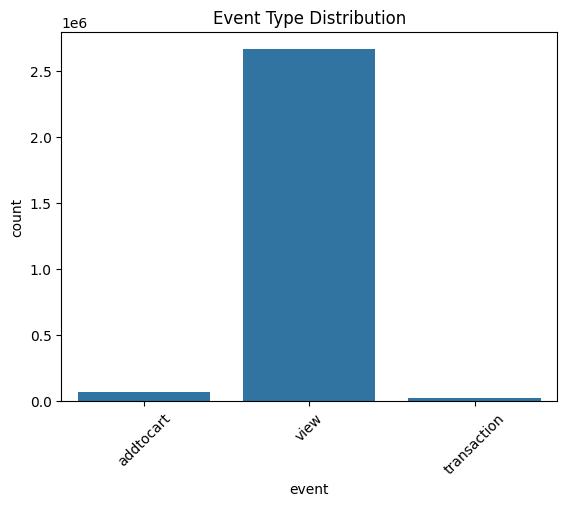

In [51]:
# countplot of event
sns.countplot(x=final_df["event"])
plt.title("Event Type Distribution")
plt.xticks(rotation=45)  # Rotate for readability
plt.show()


There is an uneven distribution of events. A very few events ended up in transaction, a few in add to cart and the majority of the events being the view event.

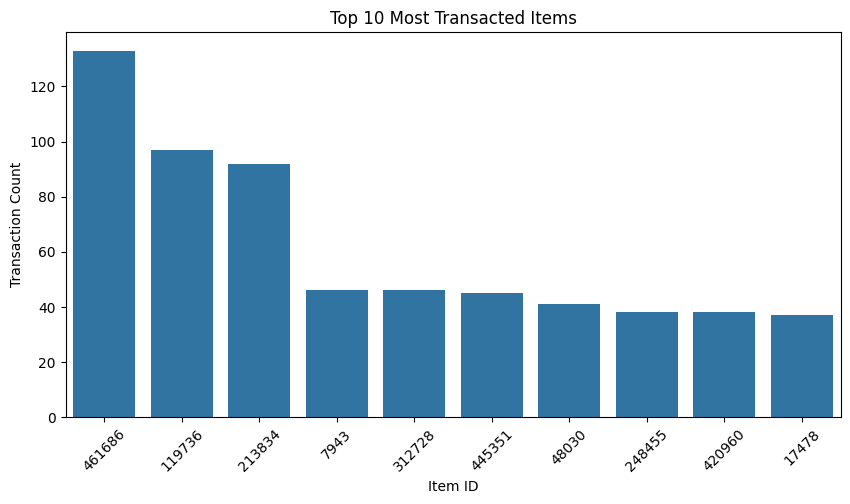

In [52]:
# Get the top 10 items
transacted_items = final_df[final_df["event"] == "transaction"]
top_items = transacted_items["itemid"].value_counts().nlargest(10)
top_items = top_items.sort_values(ascending=False)  # order ids in descending order

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index.astype(str), y=top_items.values)  # Convert IDs to string
plt.title("Top 10 Most Transacted Items")
plt.xlabel("Item ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()


In [53]:
# Split datetime
final_df["month"] = final_df["datetime"].dt.month
final_df["day"] = final_df["datetime"].dt.day
final_df["dayname"] = final_df["datetime"].dt.day_name()
final_df["hour"] = final_df["datetime"].dt.hour
final_df["minute"] = final_df["datetime"].dt.minute
final_df["second"] = final_df["datetime"].dt.second



In [54]:
final_df.head()

,datetime,visitorid,event,itemid,month,day,dayname,hour,minute,second
0,2015-05-03 03:00:04,693516,addtocart,297662,5,3,Sunday,3,0,4
1,2015-05-03 03:00:11,829044,view,60987,5,3,Sunday,3,0,11
2,2015-05-03 03:00:13,652699,view,252860,5,3,Sunday,3,0,13
3,2015-05-03 03:00:24,1125936,view,33661,5,3,Sunday,3,0,24
4,2015-05-03 03:00:26,693516,view,297662,5,3,Sunday,3,0,26


In [77]:
final_df.tail()

,visitorid,event,itemid,month,day,dayname,hour,minute,second
datetime,,,,,,,,,
2015-09-18 02:59:24,472345,view,301436,9,18,Friday,2,59,24
2015-09-18 02:59:25,1207677,view,310922,9,18,Friday,2,59,25
2015-09-18 02:59:34,255126,view,47467,9,18,Friday,2,59,34
2015-09-18 02:59:41,622226,view,345308,9,18,Friday,2,59,41
2015-09-18 02:59:47,1287495,view,98299,9,18,Friday,2,59,47


#### Time Series Analysis

##### Analysis on Views

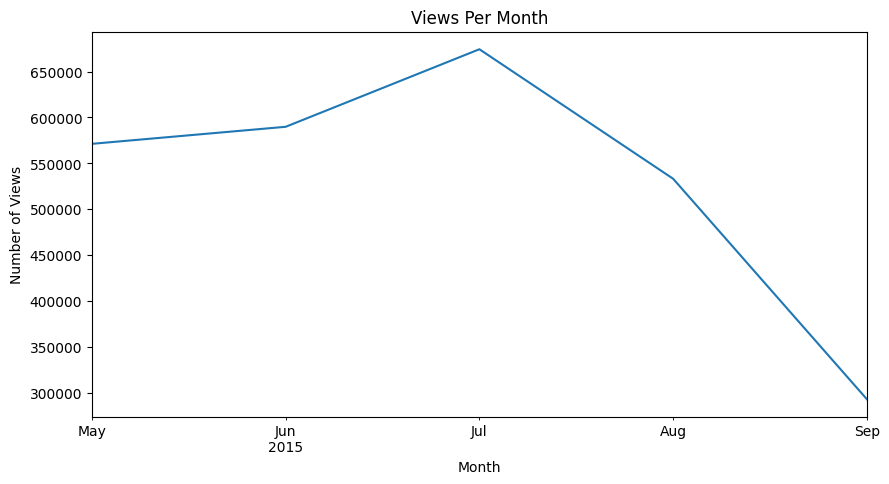

In [55]:
final_df.set_index('datetime', inplace=True) #set datetime as index
# number of views per month
monthly_views = final_df[final_df['event'] == 'view'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Views Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Views')
plt.show()

Text(0.5, 1.0, 'Views Per Day of the Week')

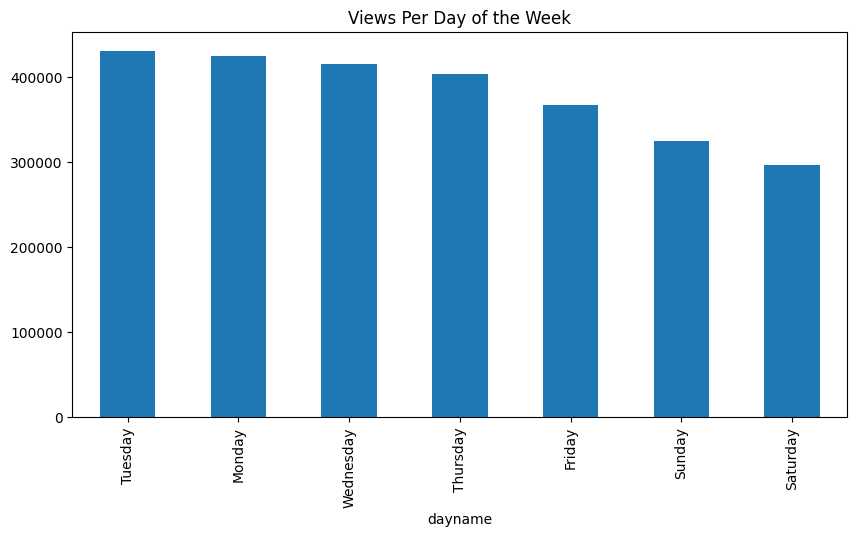

In [56]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'view'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Views Per Day of the Week')

Can be seen from the analysis that the number of views reduces as we move towards the weekends.

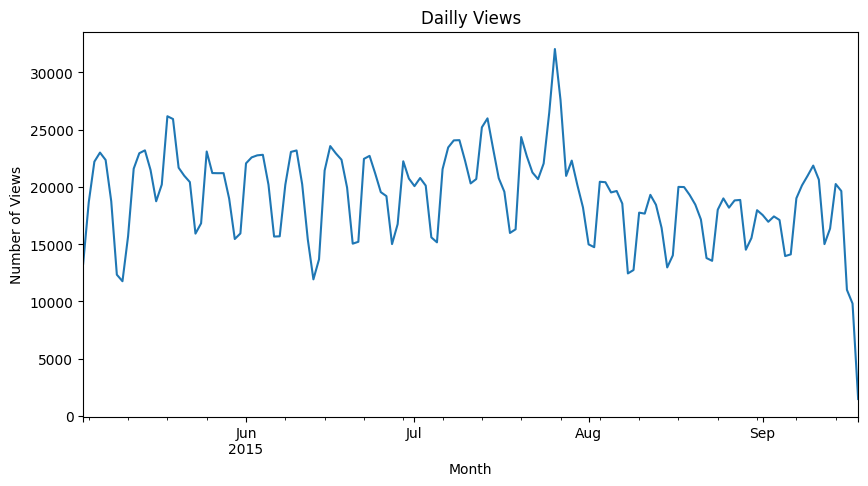

In [57]:
# number of views per day
monthly_views = final_df[final_df['event'] == 'view'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Dailly Views')
plt.xlabel('Month')
plt.ylabel('Number of Views')
plt.show()

##### Add to Cart Analysis

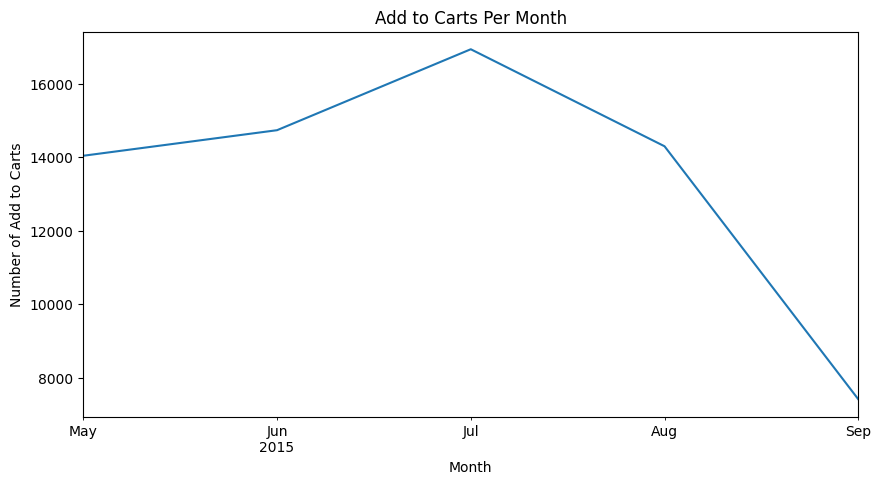

In [58]:
# number of views per month
monthly_views = final_df[final_df['event'] == 'addtocart'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Add to Carts Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Add to Carts')
plt.show()

Text(0.5, 1.0, 'Add to Carts Per Day of the Week')

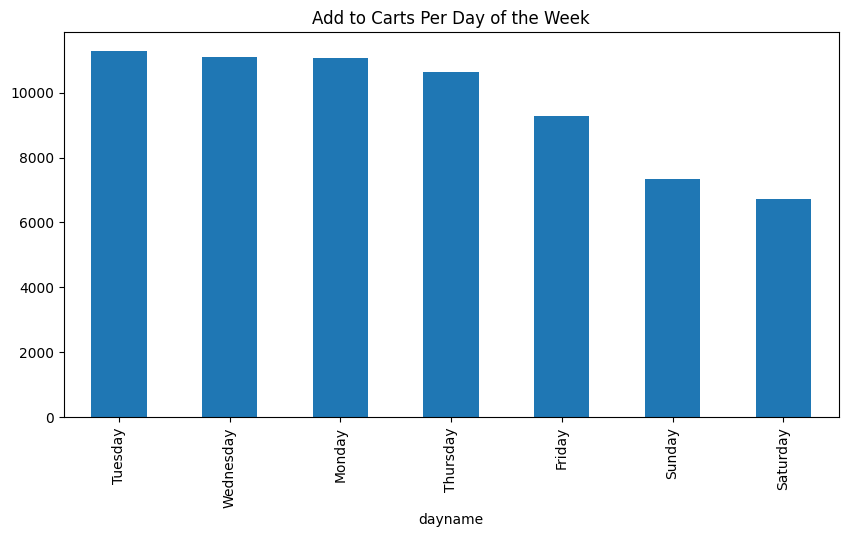

In [59]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'addtocart'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Add to Carts Per Day of the Week')

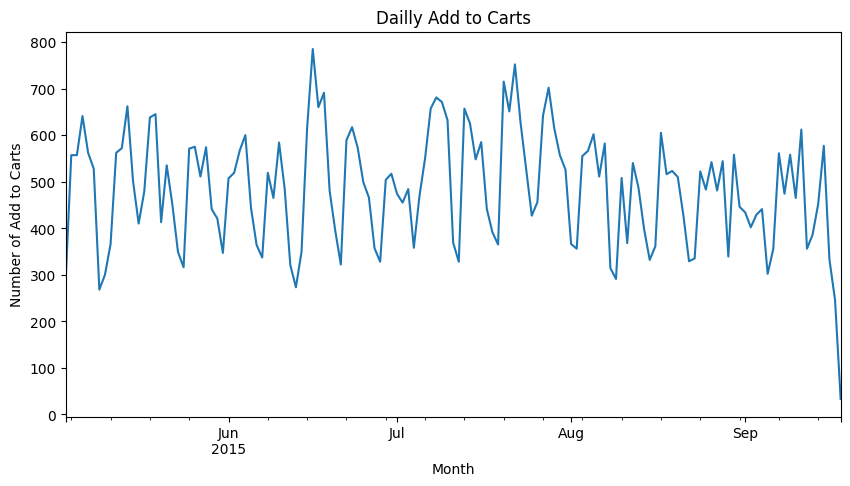

In [60]:
# number of add to carts per day
monthly_views = final_df[final_df['event'] == 'addtocart'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Dailly Add to Carts')
plt.xlabel('Month')
plt.ylabel('Number of Add to Carts')
plt.show()

- It can be observed that the number of products been added to cart normaly peaks from the beginning of the month into the middle of the month and it retards during the ending days of the month.

###### Transaction Analysis

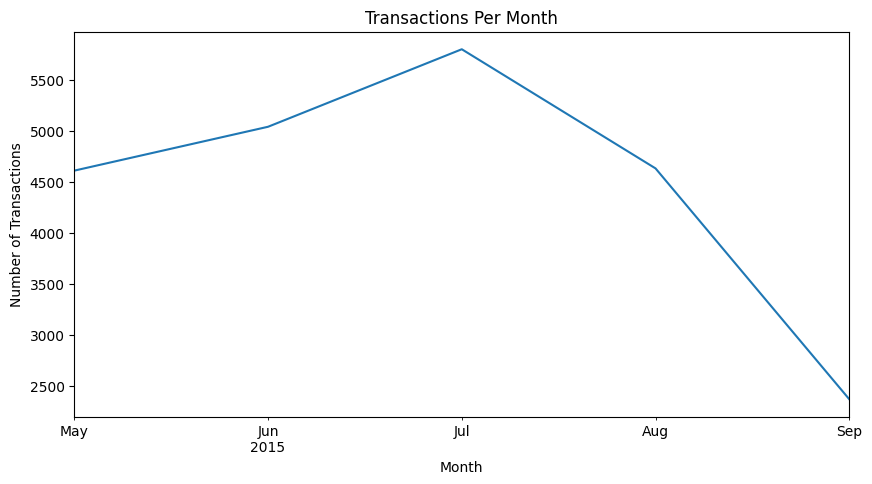

In [61]:
# number of views per month
monthly_views = final_df[final_df['event'] == 'transaction'].resample('M').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Transactions Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

Text(0.5, 1.0, 'Transactions Per Day of the Week')

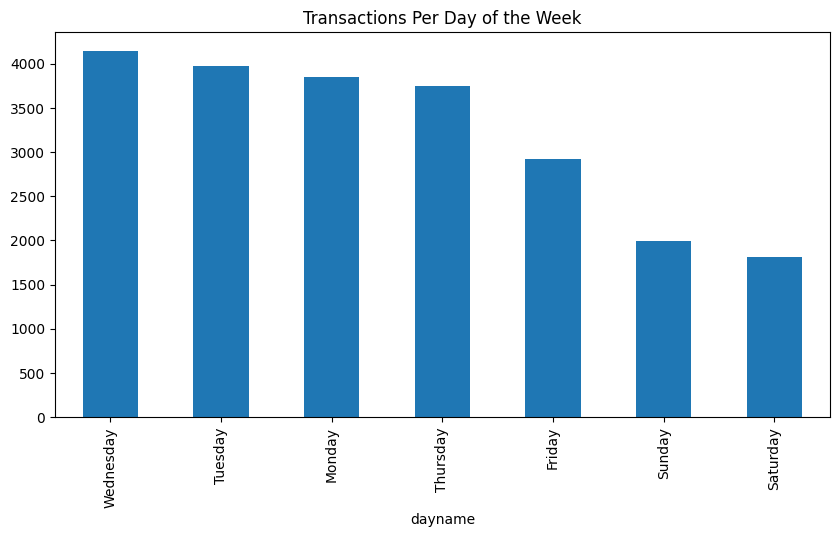

In [62]:
# Number of views per day
views_by_dayname = final_df[final_df['event'] == 'transaction'].groupby('dayname').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
views_by_dayname.plot(kind='bar')
plt.title('Transactions Per Day of the Week')

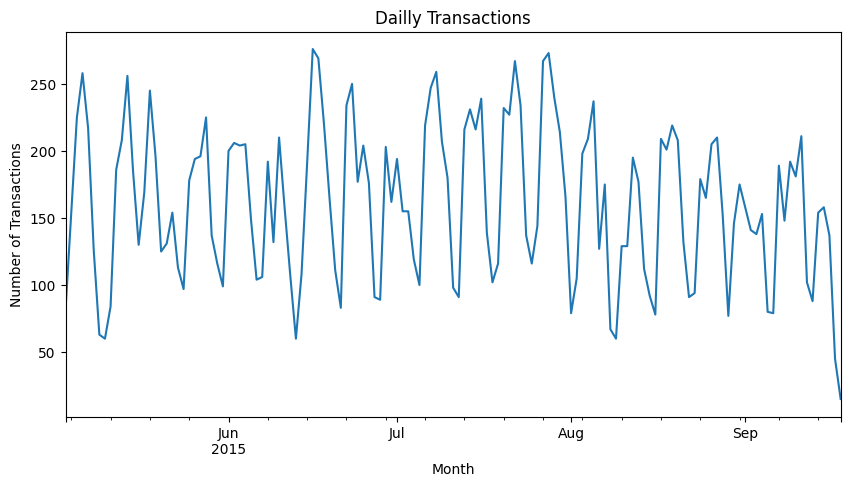

In [63]:
# number of transactions per day
monthly_views = final_df[final_df['event'] == 'transaction'].resample('D').size()
plt.figure(figsize=(10, 5))
monthly_views.plot(kind='line')
plt.title('Dailly Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

###### Busiest Hour for Most Transactions

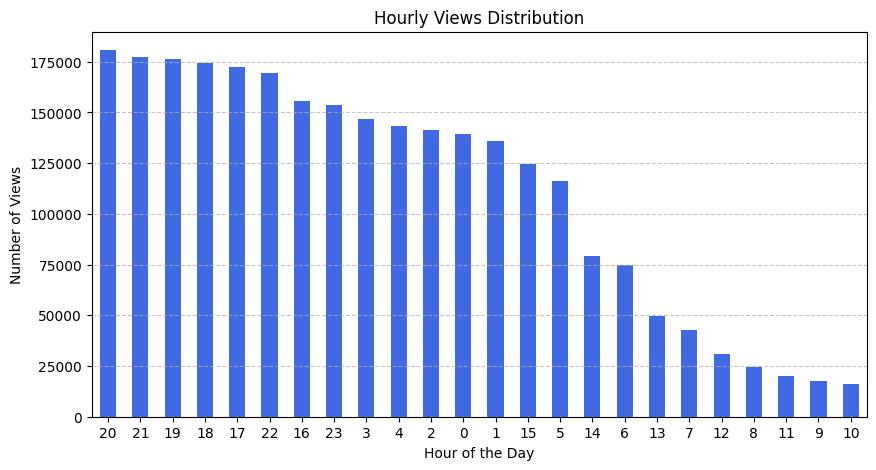

In [64]:
# most bussiest hour of the day
hourly_views = final_df[final_df['event'] == 'view'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_views.plot(kind='bar', color="royalblue")
plt.title("Hourly Views Distribution")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Views")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


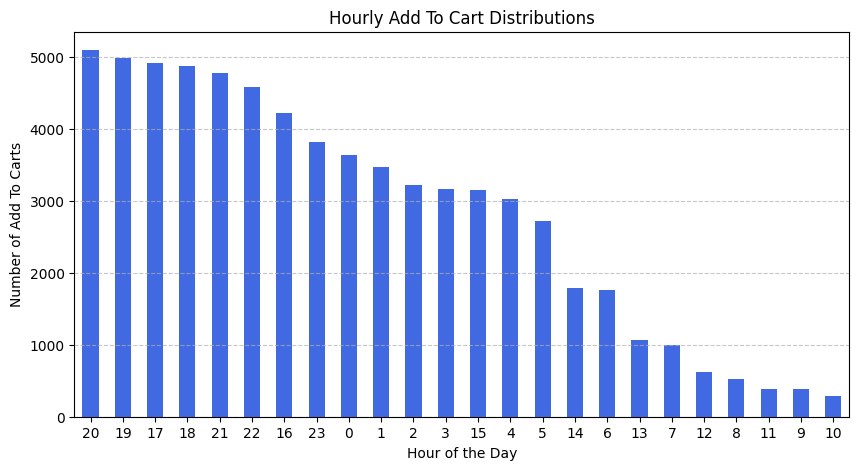

In [65]:
# most bussiest hour of the day
hourly_addtocarts = final_df[final_df['event'] == 'addtocart'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_addtocarts.plot(kind='bar', color="royalblue")
plt.title("Hourly Add To Cart Distributions")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Add To Carts")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


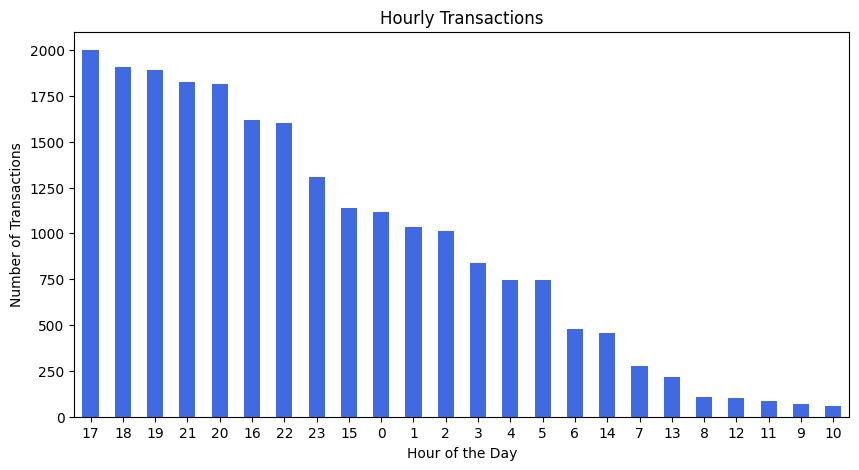

In [66]:
# most bussiest hour of the day
hourly_transactions = final_df[final_df['event'] == 'transaction'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_transactions.plot(kind='bar', color="royalblue")
plt.title("Hourly Transactions")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()


###### Top-10 Most Engaged Visitor


<Axes: xlabel='visitorid'>

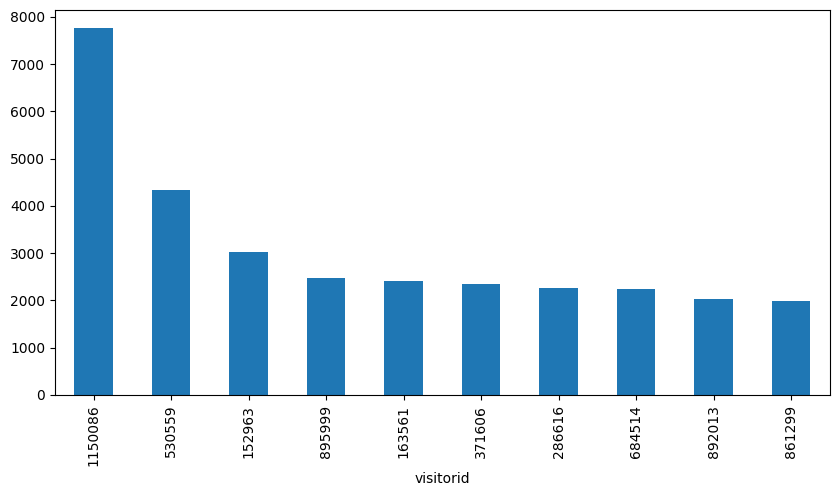

In [67]:
top_10_visitors = final_df.groupby('visitorid')['event'].count().nlargest(10)
plt.figure(figsize=(10, 5))
top_10_visitors.plot(kind='bar')

#### Bivariate Analysis


#####Event Type vs. Visitor Activity

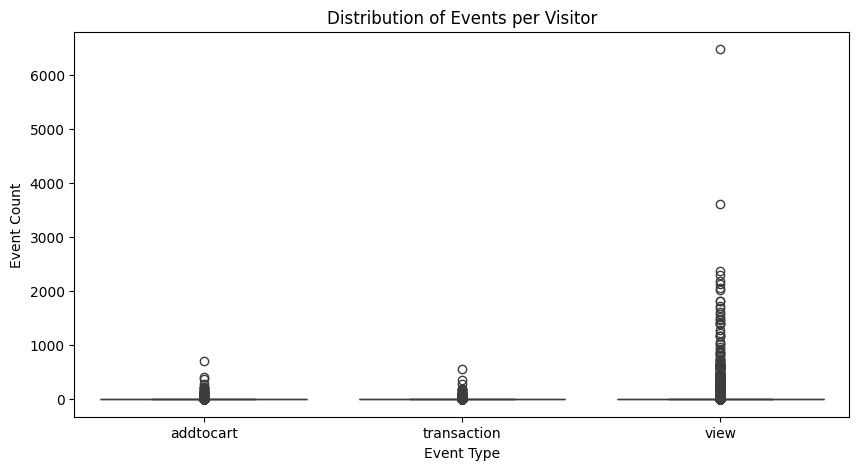

In [68]:
visitor_event_counts = final_df.groupby("visitorid")["event"].value_counts().unstack()
plt.figure(figsize=(10, 5))
sns.boxplot(data=visitor_event_counts)
plt.title("Distribution of Events per Visitor")
plt.xlabel("Event Type")
plt.ylabel("Event Count")
plt.show()


🔹 Insight: See if some visitors are more likely to transact, view, or add items to their cart.

##### Item Popularity: Views vs. (Transactions & Add to Cart)
- Objective: Identify whether high views lead to high add to carts and transactions.
- Approach:
- Scatter plot of views vs. transactions per item.
- Scatter plot of views vs. add to cart per item.




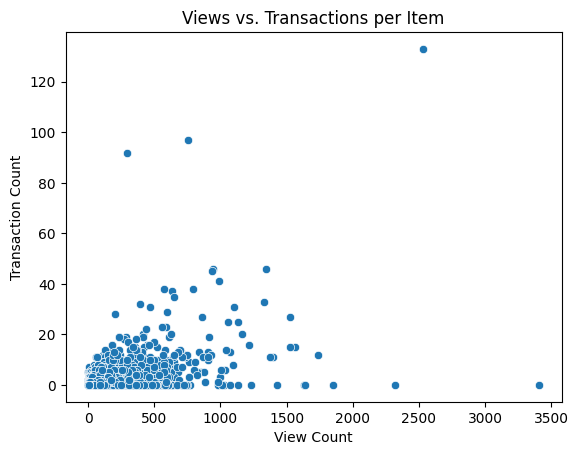

In [69]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['view'], y=item_events['transaction'])

plt.title("Views vs. Transactions per Item")
plt.xlabel("View Count")
plt.ylabel("Transaction Count")
plt.show()


Insight:High views correlate with transactions, it may indicate that items with the most views has the higher possibility of being transacted.



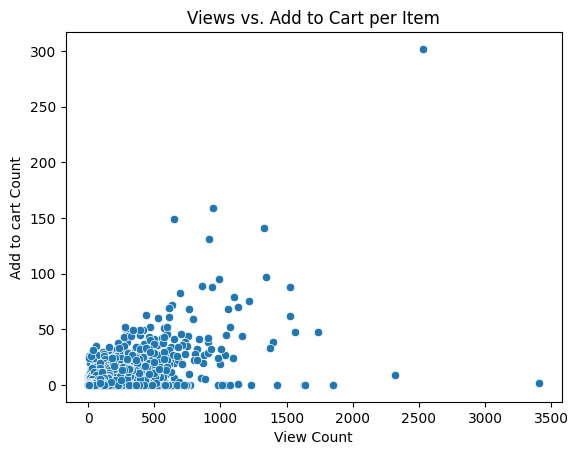

In [70]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['view'], y=item_events['addtocart'])

plt.title("Views vs. Add to Cart per Item")
plt.xlabel("View Count")
plt.ylabel("Add to cart Count")
plt.show()


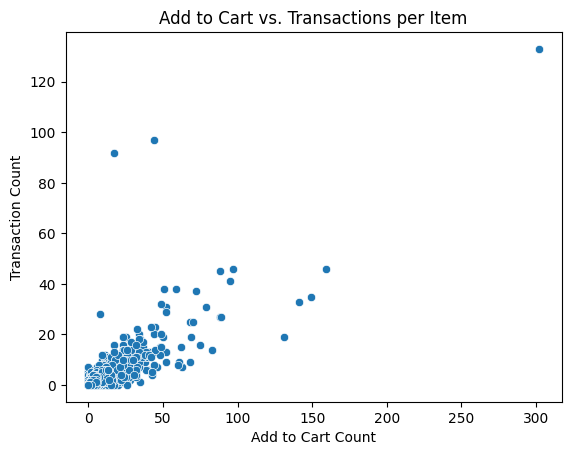

In [71]:
item_events = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
sns.scatterplot(x=item_events['addtocart'], y=item_events['transaction'])

plt.title("Add to Cart vs. Transactions per Item")
plt.xlabel("Add to Cart Count")
plt.ylabel("Transaction Count")
plt.show()

#### Answering Analytical Questions

1.Do the most viewed items also have the highest add-to-cart and transaction counts?

In [72]:
# Count occurrences of each event type per item
top_items = final_df.groupby(['itemid', 'event']).size().unstack(fill_value=0)

# Get the top 10 items for each event type
top_views = top_items['view'].nlargest(10)
top_addtocart = top_items['addtocart'].nlargest(10)
top_transactions = top_items['transaction'].nlargest(10)

# Combine results into a single DataFrame for comparison
top_items_df = pd.DataFrame({
    "Top Viewed Items": top_views.index,
    "View Count": top_views.values,
    "Top Add to Cart Items": top_addtocart.index,
    "Add to Cart Count": top_addtocart.values,
    "Top Transaction Items": top_transactions.index,
    "Transaction Count": top_transactions.values
})
top_items_df

,Top Viewed Items,View Count,Top Add to Cart Items,Add to Cart Count,Top Transaction Items,Transaction Count
0,187946,3409,461686,302,461686,133
1,461686,2534,312728,159,119736,97
2,5411,2321,409804,149,213834,92
3,370653,1854,320130,141,7943,46
4,219512,1736,29196,131,312728,46
5,298009,1640,7943,97,445351,45
6,96924,1631,48030,95,48030,41
7,309778,1565,441852,89,248455,38
8,257040,1529,257040,88,420960,38
9,384302,1527,445351,88,17478,37


Can be seen from the above dataframe, that the most viewed item wasn't the most add to cart neither the most transacted item. This implies, that transacted item doesn't depend on the number of views.

2. Does a visitor number of views for a certain item influences his/decision to add the item to cart?

Correlation between views and add-to-cart: 0.65


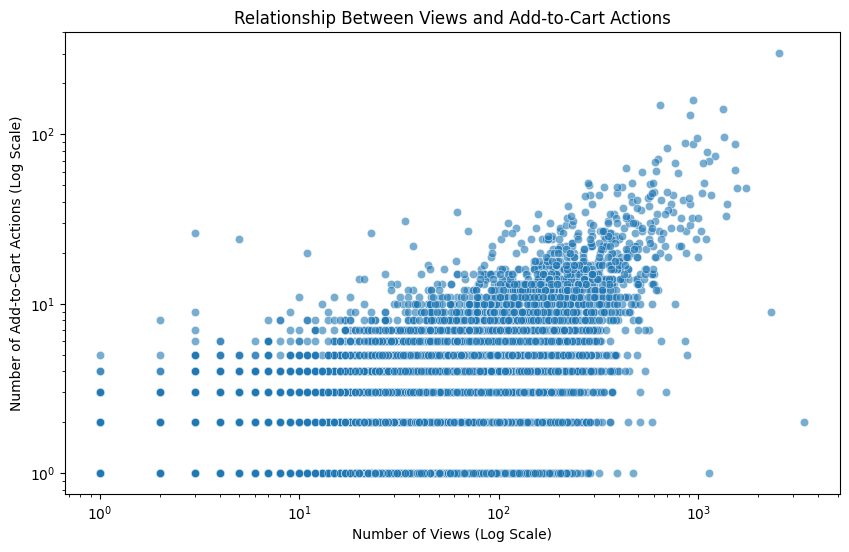

In [73]:
# Convert itemid to string
final_df["itemid"] = final_df["itemid"].astype(str)

# Aggregate number of views and add-to-cart actions per item
item_conversion = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)
# Ensure the required columns exist
if "view" in item_conversion.columns and "addtocart" in item_conversion.columns:
    # Compute conversion rate (add-to-cart / views)
    item_conversion["conversion_rate"] = item_conversion["addtocart"] / item_conversion["view"]

   # Compute correlation between views and add-to-cart actions
    correlation = item_conversion["view"].corr(item_conversion["addtocart"])
    print(f"Correlation between views and add-to-cart: {correlation:.2f}")

    # Scatter plot to visualize relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=item_conversion["view"], y=item_conversion["addtocart"], alpha=0.6)
    plt.xscale("log")  # Log scale for better visibility
    plt.yscale("log")
    plt.title("Relationship Between Views and Add-to-Cart Actions")
    plt.xlabel("Number of Views (Log Scale)")
    plt.ylabel("Number of Add-to-Cart Actions (Log Scale)")
    plt.show()


There is a positive correlation between viewed items and add to cart items. This insight will inform my decision in building the recommendation system algorithm

3. What are the most transacted item?

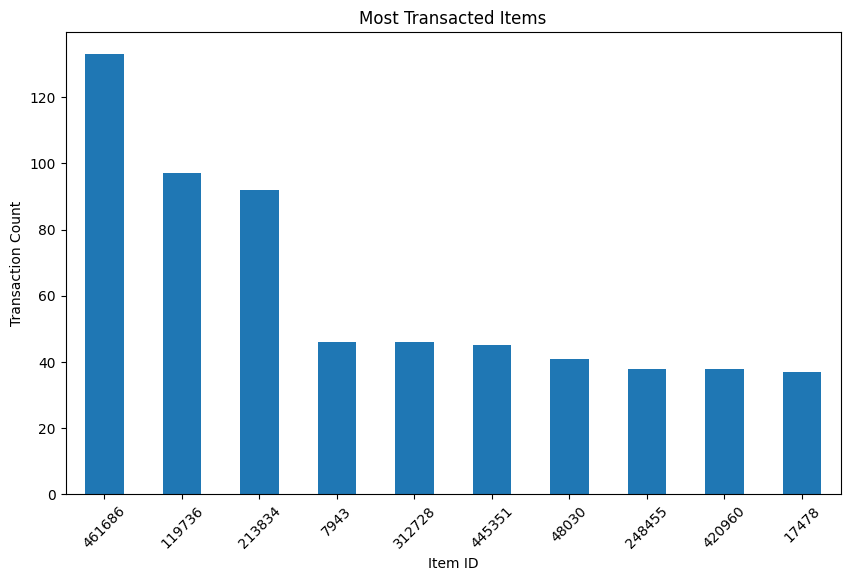

In [74]:
most_transacted_category = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)["transaction"].sort_values(ascending=False).head(10)
most_transacted_category.plot(kind="bar", figsize=(10, 6))
plt.title("Most Transacted Items")
plt.xlabel("Item ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

4. Who are the abnormal users - (bots)?

In [80]:
# Filter only "view" events
final_views_df = final_df[final_df["event"] == "view"]
# Group by user and exact second
abnormal_users = pd.pivot_table(final_views_df, index=["visitorid","month","day","hour","minute","second"], values="event",aggfunc="count")
# Sort in descending order
abnormal_users = abnormal_users.sort_values(by="event", ascending=False)
# Display top 10 potential bots
abnormal_users.head(10)

event
visitorid month day hour minute second       
216607    5     8   16   14     31          6
1317249   5     28  17   16     6           6
783664    8     20  21   18     59          5
551292    8     4   15   7      57          5
118111    9     3   17   44     19          5
1317249   5     28  17   6      24          5
                                25          5
283414    7     7   5    47     34          5
853819    7     1   2    4      19          5
137263    8     23  2    35     52          5

The users with higher number views within a second are the abnormal users and they add a lot of noise to my analysis.
- Even a faster visitor can take 1-2 seconds per item to scan,scroll or interact.
- Bots can scrape hundreds or thousands of items per second.
- They don’t wait for images to load or for UI interactions.

#### Next Steps
- >2 views per second: Likely automated bot activity.
- 3-5 views per second: Almost certainly a scripted crawler.
- 10+ views per second: Highly suspicious and likely an aggressive web scraper.
- Therefore a treshold view of 2 will be set and during the data preparation phase, I will remove all the visitors whose views exceed the treshold.

5. What are the most add to cart item?

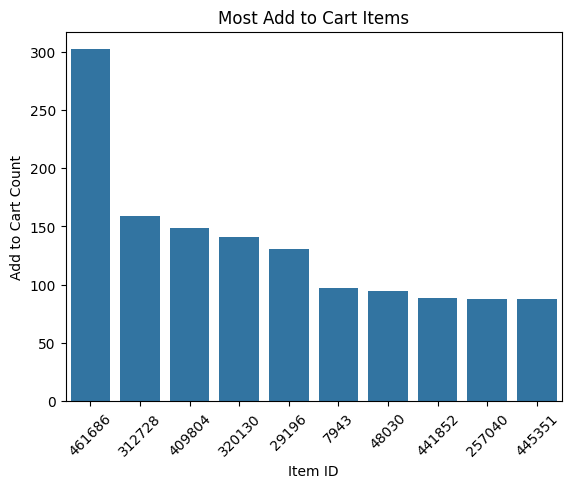

In [81]:
most_addtocart_item = final_df.groupby("itemid")["event"].value_counts().unstack(fill_value=0)["addtocart"].sort_values(ascending=False).head(10)
sns.barplot(x=most_addtocart_item.index, y=most_addtocart_item.values)
plt.title("Most Add to Cart Items")
plt.xlabel("Item ID")
plt.ylabel("Add to Cart Count")
plt.xticks(rotation=45)
plt.show()

6. Which particular time of the day has the most transactions?

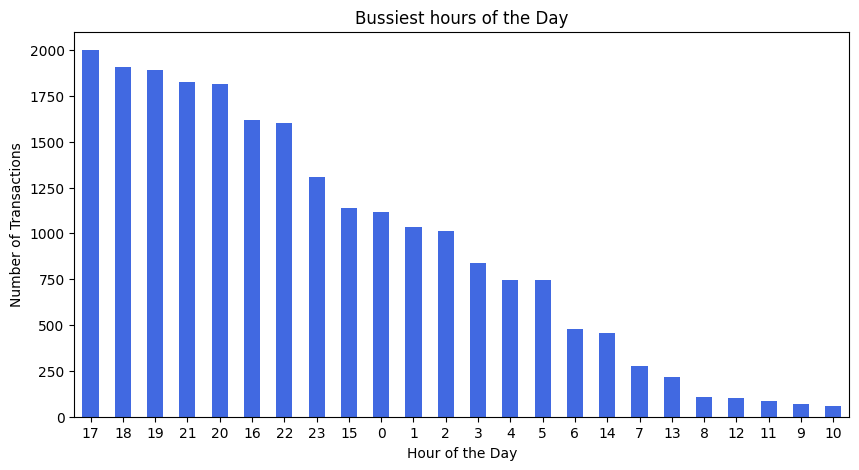

In [82]:
hourly_transactions = final_df[final_df['event'] == 'transaction'].groupby("hour").size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
hourly_transactions.plot(kind='bar', color="royalblue")
plt.title("Bussiest hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.show()

Can be observed that most transactions happens in the ending hours(evening time) of the day. From 17 hours to 23 hours the transactions peak and the transactions reduce from 0 hours to 10 hours.

7. What is the view to "add to cart" conversion rate?

In [83]:
total_views = final_df[final_df["event"] == "view"].shape[0]
total_add_to_cart = final_df[final_df["event"] == "addtocart"].shape[0]

overall_conversion_rate = (total_add_to_cart / total_views) * 100

print(f"Overall View-to-Add-to-Cart Conversion Rate: {overall_conversion_rate:.2f}%")


Overall View-to-Add-to-Cart Conversion Rate: 2.53%


- Insight: From the test above, there is a very low view to add-to-cart conversion rate which must be look at and find ways to improve view to addtocart conversion rate.

8. What is the "addtocart" to "transactions" conversion rate?

In [84]:
total_add_to_cart = final_df[final_df["event"] == "addtocart"].shape[0]
total_transactions = final_df[final_df["event"] == "transaction"].shape[0]

overall_conversion_rate = (total_transactions/ total_add_to_cart) * 100

print(f"Overall Add-to-Cart-Transaction Conversion Rate: {overall_conversion_rate:.2f}%")


Overall Add-to-Cart-Transaction Conversion Rate: 33.30%


- Insight: Although the addtocart-transaction conversion rate is more than the view-addtocart conversion rate, but is not good enough which this recommendation system aims to improve.

## Data Preparation

In [ ]:
# load first few rows of data
final_df.head()

,visitorid,event,itemid,categoryid,available,description,parentid,month,day,hour,minute,second
datetime,,,,,,,,,,,,
1970-01-01 00:23:53,257597,view,355908,1036.0,<NA>,726612,1420.0,1,1,0,23,53
1970-01-01 00:23:53,257597,view,355908,364.0,<NA>,610075,711.0,1,1,0,23,53
1970-01-01 00:23:53,257597,view,355908,400.0,<NA>,n600.000 424566,110.0,1,1,0,23,53
1970-01-01 00:23:53,257597,view,355908,1066.0,<NA>,n1020.000 424566,293.0,1,1,0,23,53
1970-01-01 00:23:53,257597,view,355908,566.0,<NA>,n726.000 424566,1492.0,1,1,0,23,53


In [ ]:
def remove_bots(df: pd.DataFrame, threshold: int = 1):
    """
    Removes abnormal users (bots) based on excessive event frequency.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing user activity.
        threshold (int): The number of events per minute-second threshold to classify as a bot.

    Returns:
        pd.DataFrame: Cleaned DataFrame with bots removed.
    """
    # Group by minute, second, and visitorid, then count events
    visitor_activity = df.groupby([df.index.minute, df.index.second, "visitorid"])["event"].count()

    # Identify visitor IDs with high activity
    bot_visitors = visitor_activity[visitor_activity > threshold].index.get_level_values("visitorid").unique()

    # Remove bot users
    df_cleaned = df[~df["visitorid"].isin(bot_visitors)]

    return df_cleaned


In [ ]:
cleaned_df = remove_bots(final_df)
cleaned_df.shape

(107886, 12)

There has been a significant drop of number of rows after the removing bots from 9869436 to 107886 rows.

In [ ]:
# load first five rows of cleaned_df
cleaned_df.head()

,visitorid,event,itemid,categoryid,available,description,parentid,month,day,hour,minute,second
datetime,,,,,,,,,,,,
1970-01-01 00:23:53,57036,view,334662,790.0,<NA>,n31440.000,1492.0,1,1,0,23,53
1970-01-01 00:23:53,57036,view,334662,776.0,<NA>,405721,727.0,1,1,0,23,53
1970-01-01 00:23:53,57036,view,334662,332.0,<NA>,769062,1667.0,1,1,0,23,53
1970-01-01 00:23:53,57036,view,334662,614.0,<NA>,769062,571.0,1,1,0,23,53
1970-01-01 00:23:53,112175,view,430845,790.0,1,NaN,1492.0,1,1,0,23,53


In [ ]:
# check for duplicates
cleaned_df.duplicated().sum()

0

In [ ]:
# count number of views per visitor
visitor_view_counts = cleaned_df[cleaned_df["event"] == "view"].groupby(["visitorid"]).size().sort_values(ascending=False)
visitor_view_counts

,0
visitorid,
986795,4
213853,3
681666,3
621661,3
575848,3
...,...
472507,1
472483,1
472444,1


In [ ]:
# calculate the percentage of null values after dropping and filling
(cleaned_df.isna().sum()/cleaned_df.shape[0])*100

,0
visitorid,0.000000
event,0.000000
itemid,0.000000
categoryid,0.000000
available,96.408246
description,9.107762
parentid,0.000000
month,0.000000
day,0.000000
hour,0.000000


#### Handling Null Values

In [ ]:
# Drop the available column
cleaned_df.drop("available", axis=1, inplace=True)

In [ ]:
catid_desc_mode = cleaned_df.groupby("categoryid")["description"].agg(pd.Series.mode).to_dict()
catid_desc_mode

{0.0: array(['1284004 327936 353870 743646 434109 688680 254353 672960',
        '769062'], dtype=object),
 1.0: '1200832',
 2.0: array([], dtype=object),
 3.0: '1116693',
 6.0: '1152934 1238769',
 8.0: '769062',
 9.0: '643171',
 11.0: 'n23040.000 628176 n12960.000',
 12.0: '472016 472016 1041261 191208',
 13.0: 'n120.000',
 15.0: '111364',
 16.0: '523129 683595',
 19.0: '1297729 n0.000 309206',
 22.0: '769062',
 23.0: '769062',
 25.0: '466400 1226584 1211562',
 28.0: '150169 274770 79212',
 30.0: '769062',
 32.0: 'n48.000',
 33.0: '1128577 1000087 421694',
 35.0: array(['1319429 661116 1257525', '178711 661116 1257525'], dtype=object),
 36.0: '91437',
 38.0: '769062',
 40.0: '769062',
 42.0: '215243',
 45.0: '250733',
 46.0: '769062',
 47.0: '910059',
 50.0: '672403',
 52.0: '1310600 1284577 704799',
 53.0: array([], dtype=object),
 54.0: '709607',
 60.0: array(['939845 n36.000', '939845 n48.000'], dtype=object),
 62.0: '530843',
 63.0: array(['420512 1175087 420512 1175087 n300.000 1

In [ ]:
# Fill in the missing values in the description column by the mode of the categoryid
cleaned_df["description"] = cleaned_df.apply(lambda x: catid_desc_mode[x["categoryid"]] if pd.isnull(x["description"]) else x["description"], axis=1)

In [ ]:
# check for null values after handling it
cleaned_df.isna().sum()

,0
visitorid,0
event,0
itemid,0
categoryid,0
description,0
parentid,0
month,0
day,0
hour,0
minute,0


In [ ]:
# strip of the "n" that is appended to the description column
cleaned_df["description"] = cleaned_df["description"].str.strip("n")

cleaned_df.head()

,visitorid,event,itemid,categoryid,description,parentid,month,day,hour,minute,second
datetime,,,,,,,,,,,
1970-01-01 00:23:53,408372,view,232591,997.0,288.000 1333885,187.0,1,1,0,23,53
1970-01-01 00:23:53,665483,view,390353,917.0,599700,1374.0,1,1,0,23,53
1970-01-01 00:23:53,175438,view,107042,936.0,769062,143.0,1,1,0,23,53
1970-01-01 00:23:53,973591,view,297141,159.0,519769,1028.0,1,1,0,23,53
1970-01-01 00:23:53,360913,view,211117,764.0,1285872,1370.0,1,1,0,23,53


#### Mapping Implicit Feedback
Implicit feedback captures user behavior instead of direct ratings. It includes actions like clicks, views, purchases, and addtocarts, which indicate interest but are not explicitly labeled by users.

- Example:
  - A user watches a movie but doesn’t rate it. We assume they liked it to some extent.
  - A user adds an item to their cart but doesn’t buy it. This still signals some level of interest.

- View (view) → The user looked at the item, but no strong interest is confirmed.
- Add to Cart (addtocart) → The user is considering buying the item. Stronger intent.
- Transaction (transaction) → The user bought the item. This is the strongest signal.

## Modeling and Evaluation

## Deployment

## Conclusion